In [11]:
from PIL import Image as Pimage
import cv2 as cv
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter 
import torchvision.utils as utils
from torch.utils.data import DataLoader
import torchvision.transforms as transf
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from torchvision.io import read_image

In [12]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Pimage.fromarray(tensor)

In [13]:


class CustomDataLoader(Dataset):

    def __init__(self, img_dir, csv_name, transform=None, target_transform=None):

        self.label_num = {}
        self.num_label = {}
        self.img_dir = img_dir
        self.from_image_to_label(img_dir, csv_name)
        self.img_labels = pd.read_csv(csv_name)
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Pimage.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
       
        return image, label
    
    def __len__(self):
        return len(self.img_labels)

    def from_image_to_label(self, image_dir, csv_name):

        num = 0
        with open(csv_name, "w") as f:
            for img_name in os.listdir(image_dir):
                img_label = img_name.split(("-"))[0]

                if img_label not in self.label_num.keys():
                    self.label_num[img_label] = num
                    self.num_label[num] = img_label
                    num = num + 1
                f.write(img_name + "," + str(self.label_num[img_label]) + "\n")
        f.close()
        
    
    def to_num(self, label):
        return self.label_num[label]
    
    def to_label(self, idx):
        return self.num_label[idx]



In [14]:
if not os.path.exists("../trasformed_dataset/"):
    img_dir = "../data/"
    t=transf.Compose([transf.ToTensor(), transf.FiveCrop(512)])
    image_dataset = CustomDataLoader(img_dir,"data.csv", transform=t)
    os.mkdir("../trasformed_dataset/")
    num = 0
    for item in image_dataset:
        images, label = item
        for image in images:
            name = "../trasformed_dataset/" + image_dataset.to_label(label) + "-" + str(num) + ".png"
            utils.save_image(image, name)
            num = num + 1

img_dir = "../trasformed_dataset/"
mod_dataset = CustomDataLoader(img_dir,"trasformed_dataset.csv", transform = transf.Compose([transf.ColorJitter(contrast=400), transf.ToTensor()]))
train_len = int(mod_dataset.__len__()*0.8)
test_len = mod_dataset.__len__()-train_len
train_set, test_set = data.random_split(mod_dataset, [train_len, test_len])

batch_size =10
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=10, shuffle=True)


In [15]:
tb = SummaryWriter("runs/")

Feature batch shape: torch.Size([3, 512, 512])
Labels batch shape: tensor([1, 2, 2, 2, 0, 2, 2, 2, 0, 2])


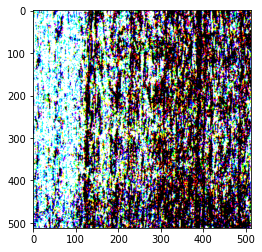

Label: 1


In [16]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features[0].size()}")
print(f"Labels batch shape: {train_labels}")
img = train_features[0]
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0),cmap='gray',vmin=0,vmax=255)
plt.show()
print(f"Label: {label}")
grid = utils.make_grid(train_features)
tb.add_image('train_images', grid)


In [17]:
class customNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 20, 64, stride=4),
                                   nn.ReLU(),
                                   nn.Conv2d(20,64,16, stride=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),
                                   nn.Flatten())

        self.fullc = nn.Sequential(nn.Linear(36864,256),
                                   nn.Linear(256, 3))    

    def forward(self, x):
        x = self.conv1(x)
        x = self.fullc(x)
        return x


In [18]:
device="cuda"
model = customNet()
tb.add_graph(model, train_features)
model.to(device)

customNet(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(64, 64), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(20, 64, kernel_size=(16, 16), stride=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
  (fullc): Sequential(
    (0): Linear(in_features=36864, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [19]:
criterion = nn.CrossEntropyLoss()
adam = optim.Adam(params = model.parameters(), lr=0.000001)
step_lr = 0.99
#adam_f = optim.lr_scheduler.ExponentialLR(optimizer=adam, gamma=step_lr)

In [20]:
device = "cuda"
epochs =1000
for epoch in range(epochs):
    running_loss = 0.0
    correct = []
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        if(device =='cuda'):
            inputs = inputs.cuda()
            labels = labels.cuda()
        adam.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        adam.step()
        running_loss += loss.item()
        
    plot_loss = running_loss/(train_dataloader.__len__()/batch_size)
    tb.add_scalar('training loss', plot_loss, epoch)
    print(f'[{epoch + 1}/ {epochs}] mean loss: {plot_loss:.8f}')

    with torch.no_grad():
        for i, data, in enumerate(test_dataloader, 0):     
            inputs, labels = data
            if(device =='cuda'):
                inputs = inputs.cuda()
            output = model(inputs)
            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            labels = labels.data.cpu().numpy()
            tmp = output == labels
            correct = [*correct, *tmp]
        
        correct = np.array(correct)
        accuracy = correct.sum()/correct.size
        print(f'[{epoch + 1}/ {epochs}]  Accuracy: {accuracy}')
        tb.add_scalar('accuracy', accuracy, epoch)
    running_loss = 0
    
print('Finished Training')

tb.close()


[1/ 1000] mean loss: 10.96489400
[1/ 1000]  Accuracy: 0.2631578947368421
[2/ 1000] mean loss: 10.60217038
[2/ 1000]  Accuracy: 0.3157894736842105
[3/ 1000] mean loss: 10.58519013
[3/ 1000]  Accuracy: 0.3157894736842105
[4/ 1000] mean loss: 10.39846748
[4/ 1000]  Accuracy: 0.3157894736842105
[5/ 1000] mean loss: 10.59430167
[5/ 1000]  Accuracy: 0.3157894736842105
[6/ 1000] mean loss: 10.33708990
[6/ 1000]  Accuracy: 0.3157894736842105
[7/ 1000] mean loss: 10.28702244
[7/ 1000]  Accuracy: 0.3157894736842105
[8/ 1000] mean loss: 10.38025022
[8/ 1000]  Accuracy: 0.3157894736842105
[9/ 1000] mean loss: 10.14946379
[9/ 1000]  Accuracy: 0.3157894736842105
[10/ 1000] mean loss: 10.21421045
[10/ 1000]  Accuracy: 0.3157894736842105
[11/ 1000] mean loss: 10.21990925
[11/ 1000]  Accuracy: 0.3157894736842105
[12/ 1000] mean loss: 10.25711827
[12/ 1000]  Accuracy: 0.3157894736842105
[13/ 1000] mean loss: 10.10130748
[13/ 1000]  Accuracy: 0.3157894736842105
[14/ 1000] mean loss: 10.02239779
[14/ 1000